In [2]:

!pip install -q kaggle

In [5]:
from google.colab import files
#Upload Kaggle API Key
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"agengputrapratama","key":"0492d742e0a75da7968b1da699d957e4"}'}

In [11]:
# Membuat direktori .kaggle jika belum ada
!mkdir -p ~/.kaggle

# Memindahkan file kaggle.json ke direktori .kaggle
!cp kaggle.json ~/.kaggle/

# Mengubah izin file kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Mengecek daftar dataset yang tersedia di Kaggle
!kaggle datasets list

ref                                                             title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                          Netflix Movies and TV Shows                          1MB  2024-04-10 09:48:38          14205        301  1.0              
kapturovalexander/time-series-for-online-store                  🏪🏬🪫 Electronic store sales data                      9MB  2024-04-30 09:33:41            809         26  1.0              
sahirmaharajj/school-student-daily-attendance                   School Student Daily Attendance                      2MB  2024-04-29 19:29:56           2276         48  1.0              
jaidalmotra/pokemon-dataset                                     P

In [14]:
import os
import zipfile
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, LSTM
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
filePath = 'https://github.com/pratama404/spamdetection/raw/main/spam_ham_dataset.csv'
df = pd.read_csv(filePath)
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [29]:
df = df.drop(columns = 'Unnamed: 0', axis = 1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [31]:
# No NaN in the data
df.isna().sum()

label        0
text         0
label_num    0
dtype: int64

In [32]:
#No NULL in the data
df.isnull().sum()

label        0
text         0
label_num    0
dtype: int64

In [33]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [34]:
stop_words = set(stopwords.words('english'))

df['text'] = df['text'].apply(lambda x: ' '.join([w for w in x if not w.lower() in stop_words]))

In [35]:
length = df['text'].str.len().max()
X = df['text'].values
y = df['label_num'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [36]:
tokenizer = Tokenizer(num_words=length, oov_token='')
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(seq_train, maxlen=20)
padded_test = pad_sequences(seq_test, maxlen=20)

In [37]:
#Architecture
model = Sequential([
    Embedding(250, 16, input_length=20),
    LSTM(64),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [38]:
model.compile(
    optimizer='Adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [39]:

#Callback Function
class accCallback(Callback):
   def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.90 and logs.get('val_accuracy') >= 0.90):
            print("\nAccuracy and Val_Accuracy has reached 90%!", "\nEpoch: ", epoch)
            self.model.stop_training = True

callbacks = accCallback()

auto_reduction_LR = ReduceLROnPlateau(
    monitor = 'val_accuracy',
    patience = 2, #if after 2 epoch not improve reduce LR by factor
    verbose = 1,
    factor = 0.2,
    min_lr = 0.000003
)

auto_stop_learn = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0,
    patience = 4,
    verbose = 1,
    mode = 'auto'
)

In [40]:

History = model.fit(
    padded_train, y_train,
    epochs = 100,
    callbacks=[callbacks, auto_reduction_LR, auto_stop_learn],
    validation_data = (padded_test, y_test),
    verbose = 2
)

Epoch 1/100
130/130 - 5s - loss: 0.5228 - accuracy: 0.7452 - val_loss: 0.5761 - val_accuracy: 0.7169 - lr: 0.0010 - 5s/epoch - 39ms/step
Epoch 2/100
130/130 - 1s - loss: 0.4605 - accuracy: 0.7735 - val_loss: 0.5533 - val_accuracy: 0.7237 - lr: 0.0010 - 1s/epoch - 11ms/step
Epoch 3/100
130/130 - 1s - loss: 0.4432 - accuracy: 0.7797 - val_loss: 0.5055 - val_accuracy: 0.7923 - lr: 0.0010 - 1s/epoch - 12ms/step
Epoch 4/100
130/130 - 1s - loss: 0.4314 - accuracy: 0.7909 - val_loss: 0.4424 - val_accuracy: 0.7894 - lr: 0.0010 - 1s/epoch - 11ms/step
Epoch 5/100

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
130/130 - 2s - loss: 0.4258 - accuracy: 0.7894 - val_loss: 0.4337 - val_accuracy: 0.7749 - lr: 0.0010 - 2s/epoch - 18ms/step
Epoch 6/100
130/130 - 2s - loss: 0.4073 - accuracy: 0.7993 - val_loss: 0.4205 - val_accuracy: 0.7845 - lr: 2.0000e-04 - 2s/epoch - 16ms/step
Epoch 7/100
130/130 - 2s - loss: 0.3929 - accuracy: 0.8046 - val_loss: 0.4004 - val_accuracy: 0.

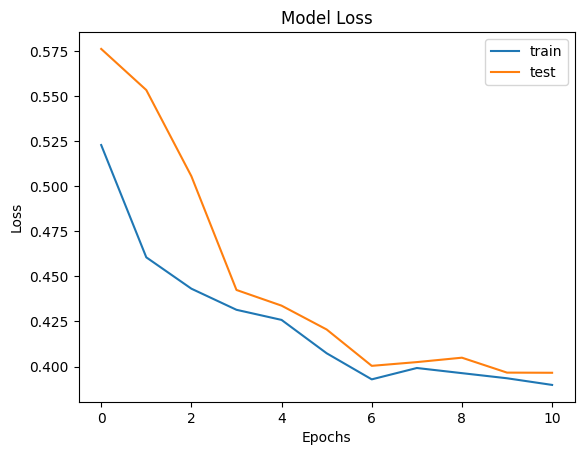

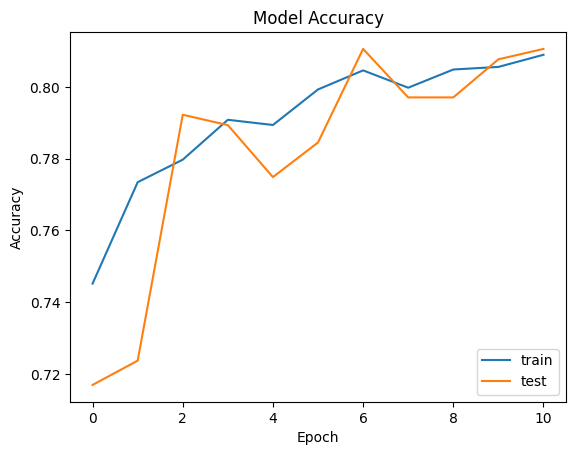

In [41]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()